# Обучение с учителем в Scikit-learn

На предыдущих уроках мы изучили инструменты, которые позволяют работать с данными: загружать, просматривать, фильтровать, преобразовывать, визуализировать. Всё это делалось с помощью библиотек `numpy`, `pandas` и `matplotlib`. Такая работа позволяет получить представление об информации, содержащейся в данных, и сделать какие-то выводы.

Когда данных имеется достаточное количество, можно доверить получение выводов по этим данным в руки специальным алгоритмам, умеющим в зависимости от поставленной задачи прогнозировать интересующую нас величину, классифицировать объекты или разбивать их на группы.

Совокупность таких алгоритмов образует дисциплину под названием _Машинное обучение_. Эту дисциплину можно разделить на две основные части: обучение с учителем и обучение без учителя. 

На этом уроке мы рассмотрим обучение с учителем. Основная особенность этого вида обучения состоит в том, что помимо набора данных, по которым мы хотим предсказать ту или иную величину, у нас имеется для этих данных набор правильных ответов. Наша задача в этом случае - построить модель, которая будет способна наиболее точно _обобщать_ эти данные, то есть предсказывать этот правильный ответ по данным, в которых этого правильного ответа у нас нет.

## Линейная регрессия

Первый алгоритм, который мы рассмотрим - _Линейная регрессия_ - предназначен для предсказания непрерывной величины. Например, это может быть цена на какой-то товар, какой-то физический показатель или иная характеристика, представляющая собой, например, вещественное число. _Задачи регрессии_ - это как раз тип задач, в которых предсказываются такого рода величины.

Для решения задач машинного обучения можно использовать библиотеку `scikit-learn` (сокращённо `sklearn`). В этой библиотеке помимо готовых реализаций алгоритмов и моделей машинного обучения есть также средства для предобработки данных и многое другое.

Также в библиотеке `sklearn` имеется набор датасетов, которые удобно использовать для знакомства с библиотекой, и на которых можно пробовать различные алгоритмы машинного обучения. Для изучения алгоритма линейной регрессии мы возьмём датасет, содержащий цены на недвижимость в Бостоне различные характеристики этой недвижимости. Для начала загрузим этот датасет:

In [1]:
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')
import requests

In [2]:
url = "http://lib.stat.cmu.edu/datasets/boston"
text = requests.get(url).text.split('\n')
feature_names = [line.split()[0] for line in text[7:21]]
DESCR = "\n".join(text[:21])
lines1 = [line.split() for line in text[22::2]]
lines2 = [line.split() for line in text[23::2]]
table = [a + b for a, b in zip(lines1, lines2)]
data = pd.DataFrame()
for line in table:
    line = [i.strip() for i in line]
    data = data._append(pd.Series(line, index=feature_names), ignore_index=True)

data = data.astype(float)
target = data['MEDV'].to_numpy()
data.drop('MEDV', axis=1, inplace=True)
feature_names = feature_names[:-1]

Функция `load_boston` загружает датасет. Загрузим его в переменную `boston`. Этот датасет представлен в виде словаря. Посмотрим, какие у этого словаря есть ключи:

Данные о недвижимости хранятся в массиве по ключу `"data"`. Посмотрим поближе на эти данные.

In [3]:
data.shape

(506, 13)

Мы видим, что это массив из 506 строк и 13 столбцов. Здесь каждая строка отвечает какому-то объекту (в нашем случае - объекту недвижимости), а столбцы - каким-то его характеристикам. Названия этих признаков хранятся в массиве по ключу `"feature_names"`:

In [4]:
feature_names

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

Не совсем ясно, что представляют из себя эти признаки. Описание всего датасета можно получить по ключу `"DESCR"`:

Данный текст содержит более подробную информацию о датасете, признаках, а также об авторах.

Наконец, массив с целевыми значениями (в нашем случае - ценами на недвижимость) можно получить по ключу `"target"`:

In [5]:
target[:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

Создадим несколько таблиц `DataFrame` для более удобного хранения данных. В таблице `X` будут храниться признаки. В качестве названий для столбцов возьмём массив `feature_names`:

In [6]:
X = pd.DataFrame(data, columns=feature_names)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Выведем информацию об этой таблице:

In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


Как видно из этой информации, данная таблица не содержит пропущенных значений.

Теперь создадим таблицу `y`, в которую запишем целевые значения:

In [8]:
y = pd.DataFrame(target, columns=["price"])
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   506 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


В этой таблице также нет пропущенных значений.

### Разбиение выборки на тренировочную и тестовую

Обычно при обучении моделей машинного обучения используют две выборки: тренировочную и тестовую. Первая нужна для того, чтобы обучить модель. Вторая - для проверки качества обученной модели: мы можем сравнить предсказанную на этих данных цену с реальной, поскольку она у нас тоже имеется.

Разбиение данных на тренировочную и тестовую выборку можно выполнить с помощью функции `train_test_split` из модуля `sklearn.model_selection`.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

С помощью параметра `test_size` можно указать, какую часть данных мы хотим выделить под тест. Если подать сюда число из отрезка $[0, 1)$, то оно будет интерпретироваться как доля тестовых объектов. Если же подать число большее или равное 1, это будет число объектов в тестовой выборке.

### Построение модели

Итак, загрузим модель линейной регрессии:

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
lr = LinearRegression()

Модель линейной регрессии по объекту $x = (x_1, \dots, x_n)$ предсказывает значение целевой переменной, используя линейную функцию 

$$f(x) = w_0 + w_1 \cdot x_1 + \dots + w_n \cdot x_n.$$ 

Задача такой модели - в процессе обучения подобрать эти коэффициенты $w_i$ так, чтобы значение этой функции было как можно более близко к реальному целевому значению $y$ объекта $x$.

Итак, чтобы обучить модель, мы используем метод `.fit`, в который передаём нашу тренировочную выборку:

In [13]:
lr.fit(X_train, y_train)

LinearRegression()

Теперь, когда модель обучена, мы можем получить предсказанные значения на объектах `X_test` с помощью метода `.predict`:

In [14]:
y_pred = lr.predict(X_test)
y_pred.shape

(127, 1)

Создадим таблицу `DataFrame` чтобы сопоставить реальные значения с предсказанными. Поскольку массив `y_pred` является двумерным, переведём его в одномерный, используя метод `.flatten`.

In [15]:
check_test = pd.DataFrame({
    "y_test": y_test["price"],
    "y_pred": y_pred.flatten(),
})

check_test.head(10)

,y_test,y_pred
395,13.1,19.894532
42,25.3,25.583589
446,14.9,17.492629
35,18.9,24.090145
80,28.0,28.019905
187,32.0,32.755592
121,20.3,21.690806
207,22.5,17.788376
93,25.0,28.479051
36,20.0,22.538475


### Метрики оценки качества моделей регрессии

Чтобы оценить то, насколько отличаются реальные значения от предсказанных, создадим отдельный столбец с их разностями:

In [16]:
check_test["error"] = check_test["y_pred"] - check_test["y_test"]
check_test.head()

,y_test,y_pred,error
395,13.1,19.894532,6.794532
42,25.3,25.583589,0.283589
446,14.9,17.492629,2.592629
35,18.9,24.090145,5.190145
80,28.0,28.019905,0.019905


Одной из основных метрик для оценки качества моделей регрессии является _средняя квадратическая ошибка_ или _mean squared error_, сокращённо _mse_. Она вычисляется как среднее от квадратов ошибок на каждом из объектов:

In [17]:
mse1 = (check_test["error"] ** 2).mean()
mse1

24.571600664196367

Эта метрика есть в готовом виде в библиотеке `sklearn`:

In [18]:
from sklearn.metrics import mean_squared_error

mean_squared_error(check_test["y_pred"], check_test["y_test"])

24.571600664196367

Также применяется _средняя абсолютная ошибка_. Она представляет из себя среднее не от квадратов ошибок, а от их модулей:

In [19]:
(np.abs(check_test["error"])).mean()

3.50716605077557

Данная метрика также доступна в готовом виде:

In [20]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(check_test["y_pred"], check_test["y_test"])

3.50716605077557

Эта метрика отличается от mse тем, что не так сильно реагирует на выбросы в данных, например, на те ситуации, в которых у некоторых объектов недвижимости сильно завышена или сильно занижена цена.

### Коэффициенты линейной регрессии

Посмотрим, какие коэффициенты подобрала наша модель на этапе обучения. Свободный коэффициент $w_0$ хранится в атрибуте `.intercept_`:

In [21]:
lr.intercept_

array([42.43853511])

Остальные коэффициенты $w_1$, $\dots$, $w_n$ хранятся в атрибуте `.coef_`:

In [22]:
lr.coef_

array([[-1.18528474e-01,  2.89228722e-02, -4.25753241e-03,
         3.03352638e+00, -1.68085587e+01,  2.95560023e+00,
         7.24310827e-03, -1.27534116e+00,  3.24935357e-01,
        -1.13937706e-02, -1.03460711e+00,  8.87746612e-03,
        -5.96775849e-01]])

Давайте визуализируем то, какой вклад вносит каждый из этих коэффициентов:

In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 6, 4
%matplotlib inline

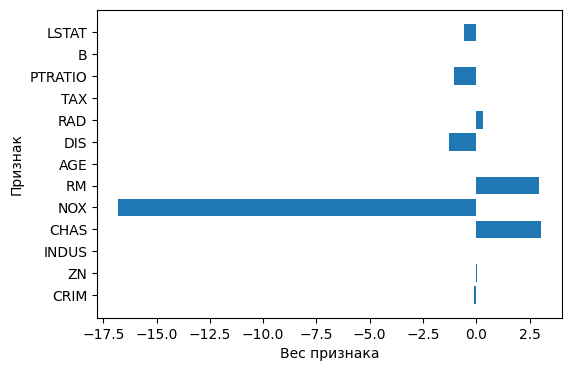

In [24]:
plt.barh(feature_names, lr.coef_.flatten())
plt.xlabel("Вес признака")
plt.ylabel("Признак")
plt.show()

### Стандартизация признаков

Не стоит торопиться с выводами о том, какой признак имеет наибольший вклад в итоговую цену. Если мы посмотрим на таблицу `X_train.describe()`, содержащую статистические данные по таблице `X_train`, мы убедимся, что значения по каждому признаку _не отмасштабированы_, т.е. имеют разный масштаб разброса значений (см. строки `mean` и `std`):

In [25]:
X_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,3.875122,10.682058,11.381029,0.071240,0.558661,6.287045,69.085488,3.754703,10.005277,416.464380,18.531398,353.081398,12.708470
std,9.076259,22.291980,6.910355,0.257566,0.117669,0.698212,27.922958,2.115737,8.946341,172.880577,2.138125,97.081759,7.100522
min,0.006320,0.000000,1.220000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.084085,0.000000,5.130000,0.000000,0.453000,5.878500,46.950000,2.071950,4.000000,279.500000,17.400000,373.290000,7.300000
50%,0.289550,0.000000,9.900000,0.000000,0.538000,6.219000,77.700000,3.092300,5.000000,345.000000,19.100000,391.270000,11.380000
75%,4.305050,12.500000,18.100000,0.000000,0.647000,6.635000,94.100000,5.116700,24.000000,666.000000,20.200000,396.070000,16.620000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Для решения этой проблемы можно применить _стандартизацию_ признаков. Для этого нужно от значений каждого признака отнять среднее значение этого признака, а затем поделить на среднее квадратическое отклонение этого признака:

$$x_{scaled} = \dfrac{x - x_{mean}}{\sigma_x}$$

После стандартизации каждый признак имеет среднее значение 0 и среднее квадратическое отклонение 1.

Изучем инструменты из библиотеки `sklearn`, с помощью которых можно провести стандартизацию данных:

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

"Обучим" объект `scaler` на наших данных, а затем сразу же получим стандартизированные значения. Это можно сделать с помощью одного общего метода `.fit_transform`. (На самом деле этот метод включает в себя два метода: `.fit` и `.transform`.)

In [27]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

Итак, попробуем обучить нашу модель заново, но уже на стандартизированных данных, и выведем аналогичную диаграмму, но уже для новой модели:

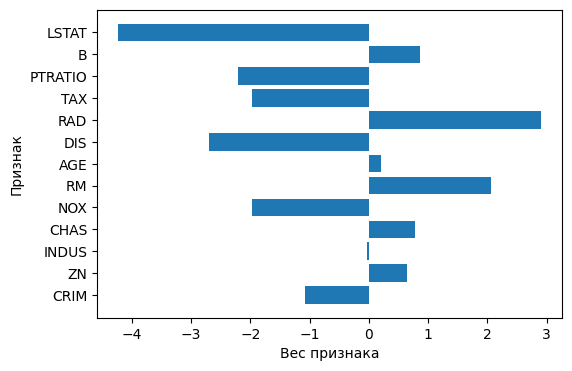

In [28]:
lr.fit(X_train_scaled, y_train)

plt.barh(feature_names, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

Мы видим, что теперь веса признаков имеют совершенно иные значения друг относительно друга.

Важно отметить, что стандартизация важна не только для отбора признаков. Стандартизация является важным этапом предобработки данных, без которого многие алгоритмы будут работать некорректно.

Попробуем обучить модель, используя лишь признаки, вес которых достаточно отличается от 0, и посмотрим, как это отразится на качестве модели:

In [29]:
X_train_scaled.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02,3.790000e+02
mean,-3.280870e-17,-5.858697e-18,2.343479e-18,-4.218262e-17,-8.225610e-16,5.764958e-16,3.069957e-16,5.624349e-17,-7.499132e-17,1.382652e-16,4.115734e-16,-5.624349e-17,2.062261e-16
std,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00,1.001322e+00
min,-4.268186e-01,-4.798218e-01,-1.472350e+00,-2.769559e-01,-1.477801e+00,-3.909483e+00,-2.373423e+00,-1.242391e+00,-1.007918e+00,-1.329054e+00,-2.777779e+00,-3.638456e+00,-1.548193e+00
25%,-4.182393e-01,-4.798218e-01,-9.057845e-01,-2.769559e-01,-8.991440e-01,-5.859034e-01,-7.937823e-01,-7.964021e-01,-6.721425e-01,-7.932958e-01,-5.298540e-01,2.084358e-01,-7.627072e-01
50%,-3.955718e-01,-4.798218e-01,-2.146036e-01,-2.769559e-01,-1.758223e-01,-9.758467e-02,3.089178e-01,-3.134977e-01,-5.602172e-01,-4.139207e-01,2.662862e-01,3.938853e-01,-1.873420e-01
75%,4.743099e-02,8.165919e-02,9.735901e-01,-2.769559e-01,7.517314e-01,4.990103e-01,8.970245e-01,6.445967e-01,1.566364e+00,1.445307e+00,7.814358e-01,4.433936e-01,5.516075e-01
max,9.388622e+00,4.012026e+00,2.370442e+00,3.610684e+00,2.657897e+00,3.575203e+00,1.108600e+00,3.962148e+00,1.566364e+00,1.705946e+00,1.624408e+00,4.519544e-01,3.562403e+00


In [30]:
important_features = [
    feature
    for feature, weight in zip(feature_names, lr.coef_.flatten())
    if np.abs(weight) > 0.5
]

print(important_features)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [31]:
lr.fit(
    X_train_scaled.loc[:, important_features],
    y_train
)

y_pred = lr.predict(X_test_scaled.loc[:, important_features])

mse2 = mean_squared_error(y_test, y_pred)

print("mse до: {}".format(mse1))
print("mse после: {}".format(mse2))

mse до: 24.571600664196367
mse после: 26.130810425665167


Стандартизация и отбор признаков иногда позволяют немного уменьшить ошибку, хотя и не всегда.

### Модели линейной регрессии с регуляризацией

В машинном обучении важной проблемой является _переобучение_, и нужно уметь бороться с переобучением обучаемой модели. Переобучение - это когда модель очень хорошо подстраивается под имеющиеся у неё тренировочные данные, однако, на тестовых данных показывает очень плохой результат.

Одним из симптомов переобучения линейных моделей являются очень большие по модулю веса. Бороться с этим можно с помощью _регуляризации_. В библиотеке `sklearn` доступны уже готовые реализации моделей линейной регрессии с L1- и L2-регуляризацией. Это, соответственно, модели `Lasso` и `Ridge` из модуля `sklearn.linear_model`.

In [32]:
from sklearn.linear_model import Lasso, Ridge

При этом, коэффициент регуляризации можно задавать с помощью параметра `alpha` при инициализации этих моделей.

In [33]:
model = Lasso(alpha=0.03)
model.fit(X_train_scaled.loc[:, important_features], y_train)
y_pred = model.predict(X_test_scaled.loc[:, important_features])
mean_squared_error(y_test, y_pred)

26.23698607276659

На графике ниже изображено изменение весов признаков при увеличении коэффициента регуляризации `alpha` от $10^{-3}$ до $10$ для модели `Lasso` (L1-регуляризация). Чем больше значение `alpha`, тем сильнее регуляризация и тем сильнее модель "штрафует" за большую абсолютную величину признаков. 

Такой метод часто используется для отбора признаков: у менее ценных признаков гораздо раньше обнуляются веса.

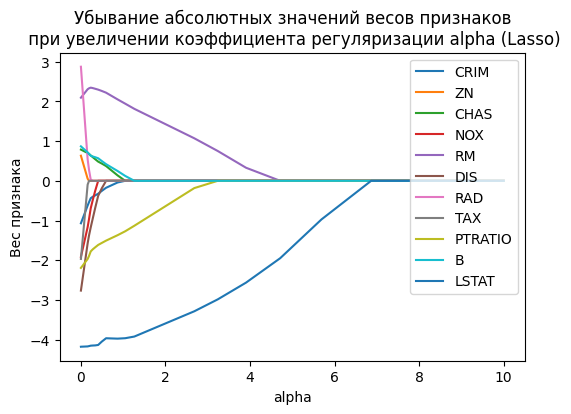

In [34]:
n = 50

coeffs = np.zeros((n, len(important_features)))
alpha_list = np.logspace(-3, 1, n)

for i, val in enumerate(alpha_list):
    lasso = Lasso(alpha=val)
    lasso.fit(X_train_scaled.loc[:, important_features], y_train)
    
    coeffs[i, :] = lasso.coef_.flatten()

for i in range(len(important_features)):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Lasso)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')

plt.legend(important_features)

При использовании модели `Ridge` (L2-регуляризация) наблюдается аналогичный эффект, однако, абсолютные значения весов убывают более плавно и примерно одновременно друг с другом.

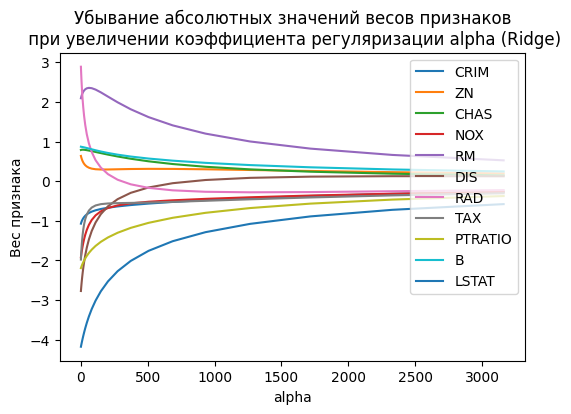

In [35]:
n = 50

coeffs = np.zeros((n, len(important_features)))
alpha_list = np.logspace(-3, 3.5, n)

for i, val in enumerate(alpha_list):
    ridge = Ridge(alpha=val)
    ridge.fit(X_train_scaled.loc[:, important_features], y_train)
    
    coeffs[i, :] = ridge.coef_.flatten()

for i in range(len(important_features)):
    plt.plot(alpha_list, coeffs[:, i])

plt.title('Убывание абсолютных значений весов признаков\n при увеличении коэффициента регуляризации alpha (Ridge)')

plt.xlabel('alpha')
plt.ylabel('Вес признака')

plt.legend(important_features)

## Логистическая регрессия

_Логистическая регрессия_ - это один из самых простых алгоритмов, используемых в _задачах классификации_: имеется набор данных, и у каждого объекта есть метка принадлежности к какому-то классу. Наша задача - предсказать эту метку для объекта. Идея логистической регрессии в том, чтобы предсказывать не метку класса, а вероятность принадлежности данного объекта к каждому из классов. 

Рассмотрим алгоритм логистической регрессии для _бинарной классификации_, т.е. случая, когда различных классов всего 2. В этом случае задача алгоритма логистической регрессии очень похожа на задачу алгоритма линейной регрессии, рассмотренного ранее: модель должна подобрать коэффициенты $w_0, w_1, \dots, w_n$. Как используются эти коэффициенты?

В начале мы делаем то же самое, что и в линейной регрессии. Мы вычисляем значение

$$z = w_0 + w_1 \cdot x_1 + \dots + w_n \cdot x_n.$$

Затем величина $z$ помещается в _сигмоидную функцию_:
$$f(z) = \dfrac{1}{1 + e^{- z}}.$$

Сигмоидная функция используется для того, чтобы преобразовать число $z$ из промежутка $(- \infty, \infty)$ в число $f(z)$ из промежутка $(0, 1)$. Причём, делается это так, что число $f(z)$ можно теперь интерпретировать как вероятность. В нашем случае это будет вероятность принадлежности объекта $x$ классу 1. Соответственно, вероятность принадлежности объекта классу 0 будет равна $1 - f(z)$.

Алгоритм логистической регрессии минимизирует функцию потерь $logloss$:

$$logloss(x) = - y \cdot \operatorname{ln} (p) - (1 - y) \cdot \operatorname{ln} (1 - p).$$

Здесь $y$ - правильный ответ на объекте $x$ (0 или 1), а $p$ - вычисленная алгоритмом вероятность принадлежности объекта $x$ классу 1.

Для того, чтобы разобраться с деталями модели логистической регрессии, мы будем использовать датасет, содержащий информацию о пассажирах Титаника. Этот датасет можно скачать [здесь](https://www.kaggle.com/c/titanic/data).

In [36]:
data = pd.read_csv("titanic_train.csv", index_col="PassengerId")
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Целевым значением для нас будет значение `"Survived"` - то, выжил пассажир или нет. Вынесем этот столбец в отдельную переменную `y`, а в переменную `X` запишем все столбцы из таблицы `data` кроме столбца `target`:

In [37]:
target = "Survived"

y = data[target]
X = data.drop(target, axis=1)

Изучим содержимое таблицы `X` более подробно:

In [38]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Name      891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 76.6+ KB


Прежде чем приступить к обучении модели, данные необходимо почистить. Мы видим, что всего у нас есть данные о 891 пассажире, однако, многие данные пропущены. Например, в столбце `"Cabin"` всего 204 непустых значения. Этот столбец мы удалим. Также удалим столбцы `"Name"` и `"Ticket"`.

In [39]:
X.drop(["Cabin", "Name", "Ticket"], axis=1, inplace=True)

В поле `"Age"` также немало пропущенных значений. Подставим в них среднее значение по имеющимся данным:

In [40]:
age_mean = X["Age"].mean()

print(age_mean)

X["Age"].fillna(age_mean, inplace=True)

29.69911764705882


Отметим, что существует и иной подход к заполнению пропущенных значений, который является более предпочтительным при достаточном количестве данных. Через некоторое время нам предстоит разбить наши данные на тренировочную и валидационную выборку. Мы могли бы сначала сделать это, а затем уже заполнить пропущенные значения средними именно по тренировочной и валидационной выборке, соответственно. Это более предпочтительный подход, поскольку средние значения получатся немного разными, что может предотвратить переобучение.

Здесь, однако, мы этого делать не будем, поскольку данных не слишком много.

Теперь рассмотрим поле `"Embarked"`. Оно текстовое, и здесь всего два пропущенных значения. Посмотрим, как часто встречаются возможные значения этого поля в датасете:

In [41]:
X["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Мы видим, что чаще всего встречается значение `"S"`. Заполним им пропущенные значения:

In [42]:
X["Embarked"].fillna("S", inplace=True)

Иногда пропущенные значения не заполняют, а используют факт их пропуска в качестве ещё одного признака. Но в этом уроке мы так делать не будем.

Обычно непрерывные значения заполняют средним или медианой, а категориальные - модой.

Чтобы использовать категориальные признаки в нашей модели, нужно перевести их в числовые. Для поля `"Sex"` это сделать легко, поскольку здесь всего два разных значения:

In [43]:
X["Sex"].unique()

array(['male', 'female'], dtype=object)

Заменим их на числовые значения 0 и 1:

In [44]:
sex_map = {
    "female": 1,
    "male": 0,
}

X["Sex"] = X["Sex"].map(sex_map)

Признак `"Embarked"` также является категориальным, но содержит более двух категорий, поэтому переводить их в числовые значения нельзя. Вместо этого используют так называемые _dummy-переменные_. Вместо одной переменной `"Embarked"` заведём три переменные `"Embarked_C"`, `"Embarked_Q"` и `"Embarked_S"`. В каждом из этих столбцов теперь будет стоять 1, если у соответствующего объекта переменная `"Embarked"` равна этому значению, и 0, если нет.

Мы могли бы сделать это вручную, однако, в библиотеке `pandas` уже есть готовая функция для этого:

In [45]:
X = pd.get_dummies(X)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,3,0,22.0,1,0,7.2500,False,False,True
2,1,1,38.0,1,0,71.2833,True,False,False
3,3,1,26.0,0,0,7.9250,False,False,True
4,1,1,35.0,1,0,53.1000,False,False,True
5,3,0,35.0,0,0,8.0500,False,False,True


Несмотря на то, что столбец `"Pclass"` является числовым, его тоже хорошо бы рассматривать как категориальный, поскольку класс пассажира - это именно категория, а не непрерывное значение. Для этого зададим для этого столбца тип `"category"`, чтобы функция `pd.get_dummies` "поняла", что этот столбец тоже нужно обработать.

In [46]:
X["Pclass"] = X["Pclass"].astype("category")

X = pd.get_dummies(X)

X.head()

,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,True,False,False,True
2,1,38.0,1,0,71.2833,True,False,False,True,False,False
3,1,26.0,0,0,7.9250,False,False,True,False,False,True
4,1,35.0,1,0,53.1000,False,False,True,True,False,False
5,0,35.0,0,0,8.0500,False,False,True,False,False,True


### Тренировочный, валидационный и тестовый датасеты

Ранее мы упомянули _валидационную_ выборку. Давайте разберёмся, что это такое и зачем она нам нужна. Многие модели машинного обучения имеют параметры, которые влияют на то, каким образом обучается модель. В таких случаях мы используем тренировочную выборку чтобы обучить модель, валидационную чтобы проверить её качество и, если нужно, подправить параметры каким-то образом. Наконец, тестовую выборку мы используем лишь для окончательной проверки качества модели.

Тестовый датасет с данными о пассажирах Титаника можно найти по вышеуказанной ссылке в файле `test.csv`. Мы же здесь работать с этими данными не будем.

Итак, разобьём наши данные на тренировочную и валидационную выборки:

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

и приступим к построению моделей.

В начале работы над любой задачей рекомендуется сперва построить простую модель, не затрачивая на неё слишком много времени. Затем можно будет уже строить более сложные модели и сравнивать их качество с качеством базовой модели.

Ранее мы перевели все наши признаки в числовые. Попробуем просто построить модель, используя все признаки:

In [48]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear")

lr.fit(X_train, y_train)

y_pred = lr.predict(X_valid)

Для подсчёта правильных ответов будем использовать метрику _accuracy_ (_точность_). Она равна отношению числа объектов, на которых целевой класс был угадан верно, к общему числу объектов.

In [49]:
from sklearn.metrics import accuracy_score

accuracy_score(y_valid, y_pred)

0.8026905829596412

Также сделаем предсказание на тренировочном датасете и посчитаем точность на нём:

In [50]:
y_pred_train = lr.predict(X_train)

accuracy_score(y_train, y_pred_train)

0.8083832335329342

Как мы видим, точность на тренировочной и обучающей выборках примерно одинаковая. Если точность на обучающей выборке оказывается сильно выше - это означает, что модель переобучилась.

Мы уже говорили о том, что алгоритм логистической регрессии позволяет получить не только предсказанную метку класса, но и вероятность принадлежности этому классу. Эти вероятности можно получить с помощью метода `.predict_proba`:

In [51]:
y_pred_proba = lr.predict_proba(X_valid)

y_pred_proba[:10]

array([[0.8882509 , 0.1117491 ],
       [0.73066434, 0.26933566],
       [0.87036678, 0.12963322],
       [0.08974896, 0.91025104],
       [0.25113486, 0.74886514],
       [0.07820798, 0.92179202],
       [0.3331492 , 0.6668508 ],
       [0.90541517, 0.09458483],
       [0.24423877, 0.75576123],
       [0.10298453, 0.89701547]])

В первом столбце полученного массива стоит вероятность каждого объекта принадлежать классу 0, а во втором - вероятность принадлежать классу 1. Можно заметить, что сумма значений каждой строки равна 1.

## Support Vector Machine

_Support Vector Machine_ или _Метод опорных векторов_ является одним из самых известных методов машинного обучения. Он включает в себя несколько алгоритмов, с помощью которых можно решать задачи как классификации, так и регрессии. 

В задаче классификации метод SVM стремится построить между объектами разных классов "линию" (в пространствах больших размерностей это называется _гиперплоскость_) так, чтобы максимизировать расстояние от этой "линии" до объектов разных классов. Во многих случаях такой метод работает лучше, чем логистическая регрессия.

Алгоритмы метода опорных векторов расположены в модуле `svm` библиотеки `sklearn`. Импортируем из этого модуля модель `SVC` (Support Vector Classifier):

In [52]:
from sklearn.svm import SVC

Алгоритмы метода SVM чувствительны к ненормализованным и нестандартизованным данным. Поэтому прежде чем строить модель, нам следует масштабировать признаки. Ранее мы уже познакомились со _стандартизацией_: тогда мы вычитали из признаков их среднее значение, а затем делили на среднее квадратическое отклонение. Здесь мы попробуем применить _нормализацию_, т.е. расположить признаки так, чтобы минимальное значение каждого признака оказалось равным 0, а максимальное - 1. Это можно сделать с помощью инструмента `MinMaxScaler` из модуля `sklearn.preprocessing`:

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)

Заметим, что для нормализации данных `X_valid` мы использовали не метод `.fit_transform`, а метод `.transform`. Это мотивировано тем, что мы хотели бы, чтобы значения признаков из массивов `X_train` и `X_valid` были согласованы, т.е. чтобы те значения, которые совпадали до нормализации, остались равными и после неё. Поэтому обучать модель заново на значениях из `X_valid` мы не хотим.

Итак, создадим модель и обучим её на наших тренировочных данных, а затем проверим её качество на валидационной выборке:

In [55]:
clf = SVC(gamma="auto")

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)
y_pred_train = clf.predict(X_train)

Оценим точность предсказания:

In [56]:
accuracy_score(y_valid, y_pred)

0.7847533632286996

In [57]:
accuracy_score(y_train, y_pred_train)

0.7874251497005988

Как мы видим, здесь мы получили более плохую точность, чем ранее, когда использовали модель логистической регрессии. Попробуем получше настроить модель.

### Тюнинг модели SVC

У модели SVC есть параметр `C`, который штрафует за ошибку классификации. По умолчанию этот параметр равен 1. Зададим несколько возможных значений для этого параметра и посмотрим, какие значения являются наиболее выгодными:

In [58]:
c_values = np.logspace(-2, 5, 36)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(c_values):
    clf = SVC(C=value, gamma="auto")
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 5 == 0:
        print('C = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

C = 0.01
	acc_valid = 0.600896860986547
	acc_train = 0.6212574850299402

C = 0.1
	acc_valid = 0.7847533632286996
	acc_train = 0.7874251497005988

C = 1.0
	acc_valid = 0.7847533632286996
	acc_train = 0.7874251497005988

C = 10.0
	acc_valid = 0.8071748878923767
	acc_train = 0.812874251497006

C = 100.0
	acc_valid = 0.8161434977578476
	acc_train = 0.8203592814371258

C = 1000.0
	acc_valid = 0.8251121076233184
	acc_train = 0.8368263473053892

C = 10000.0
	acc_valid = 0.8340807174887892
	acc_train = 0.8473053892215568

C = 100000.0
	acc_valid = 0.8071748878923767
	acc_train = 0.8592814371257484



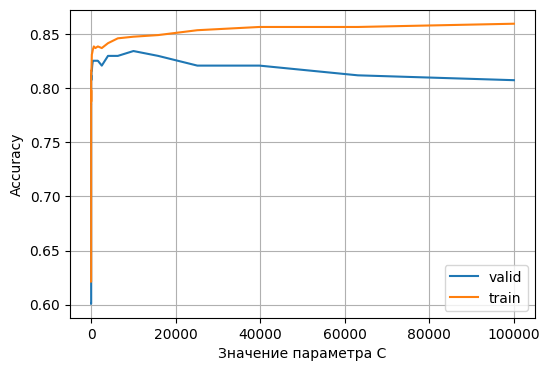

In [59]:
plt.plot(c_values, accuracy_on_valid, label="valid")
plt.plot(c_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра C')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Как мы видим, точность на валидационных данных до определённого момента растёт, но затем начинает падать. Пик точности попадает приблизительно на значение $C = 10000$. Дальше мы видим спад точности на валидационных данных, однако, точность на тренировочных данных продолжает расти. Это означает, что модель начинает переобучаться.

Можно заметить, что точность на валидационных данных при $C = 10000$ уже выше, чем при использовании логистической регрессии, а также выше, чем при использовании SVM без настройки параметров.

## KNN

KNN расшифровывается как _K Nearest Neighbours_ или _K ближайших соседей_. Это один из самых простых в понимании методов машинного обучения. Представим каждый объект из рассматриваемых данных в виде точки в пространстве признаков. Метод KNN основан на предположении, что объекты одного класса расположены в пространстве близко друг к другу. Раз так, то можно классифицировать новый объект исходя из того, какие объекты находятся в пространстве рядом с ним.

### Масштабирование признаков с использованием RobustScaler

В первую очередь, раз мы работаем с расстояниями между объектами, нам необходимо отмасштабировать признаки так, чтобы они вносили в это расстояние соизмеримый вклад. Делать это мы будем с помощью `RobustScaler`. При таком подходе масштабирования признаков минимизируется влияние выбросов в данных. Это достигается за счёт того, что при масштабировании используется медиана и интерквартильный размах.

In [60]:
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

In [61]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = RobustScaler()
cols_for_scaling = ['Age', 'SibSp', 'Parch', 'Fare']

X_train[cols_for_scaling] = scaler.fit_transform(X_train[cols_for_scaling])
X_valid[cols_for_scaling] = scaler.transform(X_valid[cols_for_scaling])

In [62]:
X_train[cols_for_scaling].describe()

,Age,SibSp,Parch,Fare
count,668.000000,668.000000,668.000000,668.000000
mean,-0.017145,0.553892,0.372754,0.787570
std,1.000766,1.185279,0.795588,2.285892
min,-2.252240,0.000000,0.000000,-0.637874
25%,-0.592240,0.000000,0.000000,-0.286822
50%,0.000000,0.000000,0.000000,0.000000
75%,0.407760,1.000000,0.000000,0.713178
max,3.869299,8.000000,6.000000,22.056664


Как мы видим, после масштабирования мода каждого из масштабируемых признаков стала равной 0.

### Классификация с помощью KNN

Итак, построим нашу модель. Идея метода заключается в том, что, классифицируя некоторый объект, мы смотрим на `K` его ближайших соседей и смотрим, представителей какого класса среди этих соседей больше всего. К такому классу мы и относим классифицируемый объект.

Построим модель для различных `K` чтобы подобрать наиболее удачное значение.

In [63]:
k_values = np.arange(1, 11)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(k_values):
    clf = KNeighborsClassifier(n_neighbors=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 2 == 0:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 1
	acc_valid = 0.7668161434977578
	acc_train = 0.9820359281437125

K = 3
	acc_valid = 0.8161434977578476
	acc_train = 0.8787425149700598

K = 5
	acc_valid = 0.8071748878923767
	acc_train = 0.8622754491017964

K = 7
	acc_valid = 0.7847533632286996
	acc_train = 0.8323353293413174

K = 9
	acc_valid = 0.7802690582959642
	acc_train = 0.8173652694610778



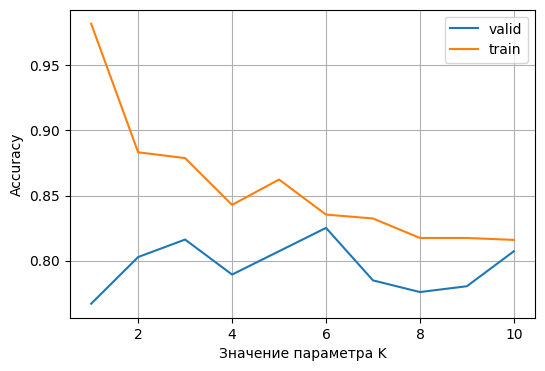

In [64]:
plt.plot(k_values, accuracy_on_valid, label="valid")
plt.plot(k_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра K')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Мы видим, что при малых значениях `K` модель склонна к переобучению. Оптимальном выбором является число $K = 6$. Построим модель ещё раз, используя эти знания.

In [65]:
clf = KNeighborsClassifier(n_neighbors=6)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8251121076233184

Полученная точность также выше, чем при использовании логистической регрессии.

## Метрики качества классификационных моделей

Ранее мы для задач классификации использовали только метрику _accuracy_, которая равна доле правильных ответов классификатора к общему количеству объектов в выборке. Такая метрика очень плохо работает в случае несбалансированной выборки (т.е. случая, когда объектов одного класса сильно больше, чем объектов другого). Представим ситуацию: мы классифицируем объекты, среди которых 950 объектов класса 1 и 50 объектов класса 0. На таких данных даже классификатор, который относит все объекты к классу 1 без разбора, даст точность 0.95. Для таких случаев рекомендуется использовать другие метрики качества.

Разберёмся подробнее в результатах, которые мы только что получили с помощью классификатора KNN. Для этого будем использовать _confusion matrix_, т.е. _матрицу ошибок_.

In [66]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_pred)

print(cm)

[[123  11]
 [ 28  61]]


Данная матрица содержит в себе 4 значения:

* True Negative (TN) - случаи, когда мы правильно классифицировали объект как объект класса 0 (левое верхнее значение)
* False Positive (FP) - случаи, когда мы классифицировали объект как объект класса 1, хотя, он на самом деле имеет класс 0 (правое верхнее)
* False Negative (FN) - классифицировали объект как объект класса 0, а на самом деле он имеет класс 1 (левое нижнее)
* True Positive (TP) - правильно классифицировали объект как объект класса 1 (правое нижнее)

In [67]:
TP = ((y_pred == 1) & (y_valid) == 1).sum()
TP

61

In [68]:
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

### Точность и полнота

Метрика _precision_ (точность) является долей объектов класса 1, верно классифицированных моделью, к общему числу объектов, которые модель классифицировала как объекты класса 1. Т.е.

$$precision = \dfrac{TP}{TP + FP}.$$

In [69]:
precision = TP / (TP + FP)
precision

0.8472222222222222

Данную метрику можно также сразу посчитать по предсказанным данным с помощью функции `precision_score` из модуля `sklearn.metrics`.

Метрика _recall_ (_полнота_) является долей найденных моделью объектов класса 1:

$$recall = \dfrac{TP}{TP + FN}.$$

In [70]:
from sklearn.metrics import recall_score

recall_score(y_valid, y_pred)

0.6853932584269663

### F-мера

Хорошим способом комбинировать эти две метрики является мера $F_1$:

$$F_1 = 2 \cdot \dfrac{precision \cdot recall}{precision + recall}.$$

In [71]:
from sklearn.metrics import f1_score

f1_score(y_valid, y_pred)

0.7577639751552795

### AUC

Следующей часто используемой метрикой является метрика _AUC_ или _Area Under Curve_ (площадь под кривой). Часто в качестве кривой используется кривая _ROC_. Разберёмся, что это за кривая. Для этого нам нужно получить не просто метки класса для каждого классифицируемого объекта, а вероятности принадлежности к классу 1. Это можно сделать с помощью метода `.predict_proba`:

In [72]:
y_pred_proba = clf.predict_proba(X_valid)

print(y_pred_proba[:10])

[[0.66666667 0.33333333]
 [0.83333333 0.16666667]
 [1.         0.        ]
 [0.         1.        ]
 [0.5        0.5       ]
 [0.         1.        ]
 [0.16666667 0.83333333]
 [0.83333333 0.16666667]
 [0.5        0.5       ]
 [0.16666667 0.83333333]]


Данный метод возвращает для каждого классифицируемого объекта список из двух значений. Первой идёт вероятность принадлежности классу 0, а второй - вероятность принадлежности классу 1. Как мы видим, сумма двух значений всегда равна 1. 

Нам понадобится лишь вероятность принадлежности классу 1:

In [73]:
y_pred_proba = y_pred_proba[:, 1]

print(y_pred_proba[:5])

[0.33333333 0.16666667 0.         1.         0.5       ]


Посмотрим, как распределяются эти вероятности. Для этого построим две гистограммы. В первом случае будем смотреть на распределение вероятностей на объектах, принадлежащих классу 1, а во втором - на объектах класса 0.

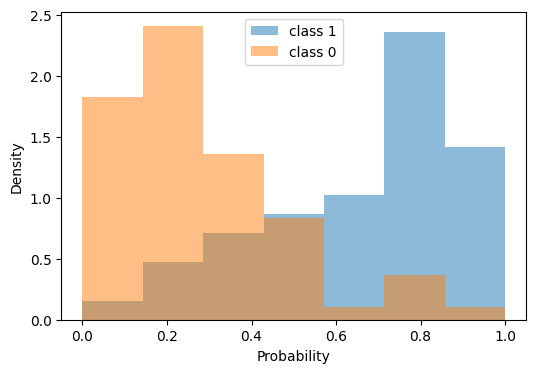

In [74]:
plt.hist(y_pred_proba[y_valid == 1], bins=7, density=True, label='class 1', alpha=0.5)
plt.hist(y_pred_proba[y_valid == 0], bins=7, density=True, label='class 0', alpha=0.5)

plt.xlabel("Probability")
plt.ylabel("Density")

plt.legend()

Мы видим, что наша модель неплохо разделила объекты классов 0 и 1.

Теперь построим ROC-кривую. Для этого нам понадобятся следующие значения:

* $FPR = \dfrac{FP}{FP + TN}$ - False Positive Rate, т.е. доля False Positive

* $TPR = \dfrac{TP}{TP + FN}$ - True Positive Rate, т.е. доля True Positive (совпадает с recall)

На основании этих метрик строится ROC-кривая. Посчитаем эти значения с помощью функции `roc_curve` из модуля `sklearn.metrics`:

In [75]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba, pos_label=1)

Здесь параметр `pos_label` - метка того класса, который мы считаем позитивным. В нашем случае это класс 1.

Идея ROC-кривой состоит в следующем. Если у нас есть массив с вероятностями принадлежности объектов классу 1, то порог, по которому принимается решение, мы можем выбирать сами. Например, если мы возьмём в качестве порога 1, то модель будет классифицировать объекты как объекты класса 1 только если классификатор на них абсолютно уверен (т.е. вероятность равна 1). Мы также можем взять этот порог и меньше: $0.9$, $0.7$, $0.5$ и т.д. Каждому такому выбору порога соответствуют свои значения FPR и TPR.

Итак, будем постепенно уменьшать порог, начиная с 1, и смотреть, в какие моменты значения FPR и TPR меняются. Как только какое-нибудь из этих значений изменилось, мы будем сохранять текущее значение FPR, TPR, а также значение порога, на котором произошло изменение. Именно эти значения и возвращает функция `roc_curve`.

Например, рассмотрим четвёртый элемент в массиве `thresholds`:

In [76]:
th = thresholds[3]
th

0.6666666666666666

Теперь посмотрим, какие значения FPR и TPR соответствуют этому порогу:

In [77]:
print(fpr[3])
print(tpr[3])

0.08208955223880597
0.6853932584269663


Эти же значения можно посчитать и руками:

In [78]:
fpr_ = ((y_valid==0) & (y_pred==1) & (y_pred_proba>=th)).sum() / (y_valid==0).sum()
tpr_ = ((y_valid==1) & (y_pred==1) & (y_pred_proba>=th)).sum() / (y_valid==1).sum()

print(fpr_)
print(tpr_)

0.08208955223880597
0.6853932584269663


Теперь ROC-кривая просто строится по точкам, которые получаются, если FPR откладывать по оси x, а TPR - по оси y:

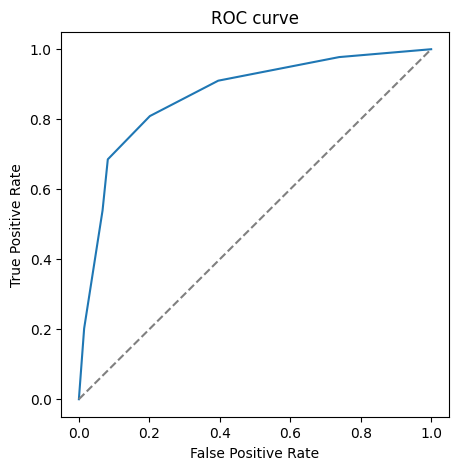

In [79]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

plt.show()

Соответственно, метрика ROC AUC - это площадь под кривой ROC. Для константного классификатора эта метрика равна $0.5$, поэтому для хороших классификаторов она должна быть между $0.5$ и $1$.

Посчитать эту метрику можно и сразу, воспользовавшись соответствующей функцией из библиотеки `sklearn`:

In [80]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_valid, y_pred_proba)

0.8682710045279222

## Деревья решений и случайный лес

_Дерево решений_ - один из самых легко интерпретируемых методов машинного обучения. При использовании этого метода по тренировочным данным строится бинарное дерево, в каждом узле которого происходит разбиение данных по значению какого-то признака. На конце каждой ветки дерева (т.е. в каждом её _листе_) располагается метка класса, к которому следует отнести те объекты, которые дошли до соответствующего листа.

In [81]:
from sklearn.tree import DecisionTreeClassifier

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

Разберёмся с тем, какие параметры есть у модели `DecisionTreeClassifier`, и как их настраивать. Первый интересующий нас параметр - максимальная глубина дерева или `max_depth`. Деревья большой глубины склонны к переобучению: модель просто слишком детально подстраивается под тренировочные данные.

In [82]:
max_depth_values = np.arange(2, 20)

accuracy_on_valid = []
accuracy_on_train = []

for i, value in enumerate(max_depth_values):
    clf = DecisionTreeClassifier(max_depth=value)
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_valid)
    y_pred_train = clf.predict(X_train)
        
    acc_valid = accuracy_score(y_valid, y_pred)
    acc_train = accuracy_score(y_train, y_pred_train)
    
    if i % 4 == 2:
        print('K = {}'.format(value))
        print('\tacc_valid = {}'.format(acc_valid))
        print('\tacc_train = {}\n'.format(acc_train))
    
    accuracy_on_valid.append(acc_valid)
    accuracy_on_train.append(acc_train)

K = 4
	acc_valid = 0.8071748878923767
	acc_train = 0.842814371257485

K = 8
	acc_valid = 0.7623318385650224
	acc_train = 0.8967065868263473

K = 12
	acc_valid = 0.7354260089686099
	acc_train = 0.9565868263473054

K = 16
	acc_valid = 0.7309417040358744
	acc_train = 0.9790419161676647



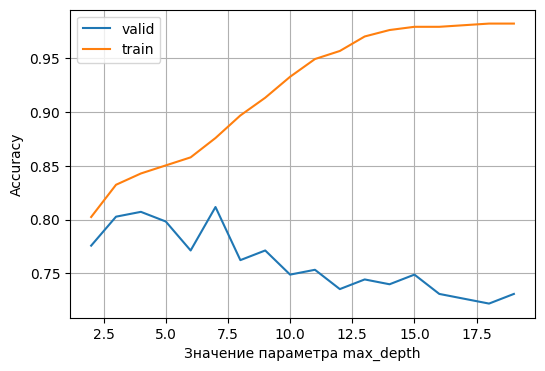

In [83]:
plt.rcParams['figure.figsize'] = 6, 4

plt.plot(max_depth_values, accuracy_on_valid, label="valid")
plt.plot(max_depth_values, accuracy_on_train, label="train")

plt.xlabel('Значение параметра max_depth')
plt.ylabel('Accuracy')

plt.legend()
plt.grid()

plt.show()

Это мы и наблюдаем: при достаточно больших значениях параметра `max_depth` точность на тренировочных данных почти достигает 1. На валидационных же данных точность достигает своего пика приблизительно на значении `max_depth = 7`, а затем начинает падать.

In [84]:
clf = DecisionTreeClassifier(max_depth=7)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

0.8071748878923767

Даже в лучшем случае мы получаем точность, которая уступает точности других рассмотренных нами моделей. 

Рассмотрим теперь алгоритм, основанный на деревьях решений, но являющийся более сложным, а именно со _Случайным лесом_ или _Random forest_.

### Random Forest

В этом алгоритме используется _ансамбль_ деревьев решений. Для каждого обучаемого дерева решений создаётся подвыборка из исходной тренировочной выборки, кроме того, при обучении каждого дерева используется лишь часть признаков. 

На этапе предсказания мы учитываем ответы, полученные каждым из деревьев, и выбираем тот ответ, за который "проголосовало" наибольшее количество деревьев. Это позволяет, в частности, уменьшить влияние переобучения каждого из деревьев.

In [85]:
from sklearn.ensemble import RandomForestClassifier

Рассмотрим несколько параметров данной модели:

* `n_estimators` - число деревьев в ансамбле
* `max_features` - максимальное число признаков, которое может быть использовано при построении каждого дерева
* `max_depth` - максимальная глубина дерева

Для того, чтобы выбрать подходящий набор параметров, можно использовать _Grid search_ или поиск по сетке. Этот метод используется для того, чтобы перебрать все возможные комбинации параметров и выбрать ту комбинацию, которая максимизирует выбранную нами метрику. Можно воспользоваться готовой реализацией из библиотеки `sklearn`.

In [86]:
from sklearn.model_selection import GridSearchCV

Зададим сетку параметров, по которой мы хотели бы провести поиск:

In [87]:
parameters = {
    'n_estimators': [150, 200, 250],
    'max_features': np.arange(5, 9),
    'max_depth': np.arange(5, 10),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=parameters,
    scoring='accuracy',
    cv=5,
)

`GridSearchCV` - это классификатор, который строится на основе модели `estimator`, пробегая все комбинации значений из `param_grid`. Для каждой комбинации параметров по кросс-валидации на указанном количестве _фолдов_ считается метрика, указанная в `scoring`. Наконец, выбирается та комбинация параметров, при которой выбранная метрика оказалась максимальной, и дальше для предсказания используется именно этот набор параметров.

### Кросс-валидация

При оценке каждой построенной в процессе модели используется _кросс-валидация_. Это метод, при котором вся обучающая выборка разбивается на заданное число _фолдов_ (частей), и по очереди каждый из этих фолдов выкидывается из тренировочной выборки и используется для валидации. Другими словами, если `cv=5`, то мы строим 5 моделей, для каждой из них выкидывая один из фолдов из обучающей выборки. Затем значения выбранной метрики усредняются на этих 5 моделях.

In [88]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'max_features': array([5, 6, 7, 8]),
                         'n_estimators': [150, 200, 250]},
             scoring='accuracy')

Для ознакомления с результатами Grid search можно использовать атрибут `.cv_results_`. Удобнее всего визуализировать эти результаты в виде `DataFrame`:

In [ ]:
cv_results = pd.DataFrame(clf.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score', 'mean_train_score', 'std_train_score'],
      dtype='object')

Посмотрим, как выбранные нами параметры влияют на точность модели:

In [ ]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'mean_train_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,mean_train_score
15,6,6,150,0.826347,0.892967
21,6,8,150,0.824850,0.897831
17,6,6,250,0.824850,0.893716
12,6,5,150,0.824850,0.893714
14,6,5,250,0.823353,0.892593
11,5,8,250,0.823353,0.875382
55,9,7,200,0.821856,0.945737
54,9,7,150,0.821856,0.943868
35,7,8,250,0.821856,0.918791
24,7,5,150,0.821856,0.908310


Мы видим, что наилучшей точности модель достигает, если взять 150 деревьев глубины не более 6, и на каждом из них выбирать не более 6 признаков. При этом модель всё ещё даёт ощутимо более хороший результат на обучающей выборке, но уже не так сильно переобучается.

Наилучшие параметры можно также посмотреть, используя атрибут `.best_params_`.

In [ ]:
clf.best_params_

{'max_depth': 6, 'max_features': 6, 'n_estimators': 150}

Полученная в результате модель аналогична такой модели:

In [1]:
clf = RandomForestClassifier(max_depth=6, max_features=6, n_estimators=150)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_valid)

accuracy_score(y_valid, y_pred)

NameError: name 'RandomForestClassifier' is not defined